In [3]:
import plotly.graph_objects as go
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.optimize import curve_fit
from scipy import signal
from scipy import lfilter
import csv
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import numpy.polynomial.polynomial as poly

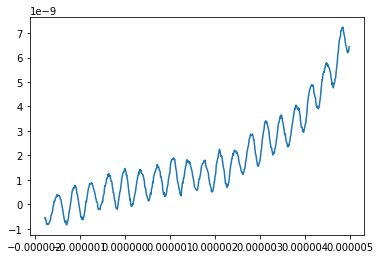

In [4]:
fd_osc={}
fd_osc_bw={}

for i in range (3):
    i=i+1
    csvfile=f'fd/Oscillaties/fd_cells_10nN_{i}_forward.csv'
    csvfile_bw=f'fd/oscillaties/fd_cells_10nN_{i}_backward.csv'
#csvfile='W:/staff-bulk/tnw/BN/AJ/Shared/Marre/NFP4cryoEM/FD_curves/20200220/hopeful.csv'
    fd_osc[i]=pd.read_csv(csvfile, header=None, delimiter=";").to_numpy()
    fd_osc_bw[i]=pd.read_csv(csvfile_bw, header=None, delimiter=";").to_numpy()

for i in range(3):
    i=i+4
    csvfile=f'fd/Oscillaties/fd_cells_50nN_{i}_forward.csv'
    csvfile_bw=f'fd/oscillaties/fd_cells_50nN_{i}_backward.csv'
#csvfile='W:/staff-bulk/tnw/BN/AJ/Shared/Marre/NFP4cryoEM/FD_curves/20200220/hopeful.csv'
    fd_osc[i]=pd.read_csv(csvfile, header=None, delimiter=";").to_numpy()
    fd_osc_bw[i]=pd.read_csv(csvfile_bw, header=None, delimiter=";").to_numpy()


fig, ax = plt.subplots()
for i in range(1):
    i=i+1
    ax.plot(fd_osc[i][:,0],fd_osc[i][:,1], color='tab:blue')



# FFT

1903044.8717949148


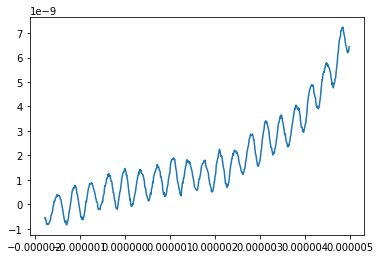

In [152]:
y=fd_osc[1][:,1]#[0:rounded_length]
x=fd_osc[1][:,0]#[0:rounded_length]
N=len(y)
step=(x[1]-x[0])

ft=np.fft.rfft(y, n=N)
power=np.abs(ft)
sample_freq=np.fft.rfftfreq(y.size, d=step)

plt.plot(sample_freq, power)

s = np.fft.irfft(ft, n=N)
fig, ax= plt.subplots()
ax.plot(x, s)

print(freq[19])

In [108]:
round_down(395, 2)

394

# Frequency noise

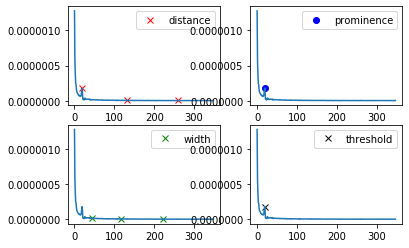

Text(0, 0.5, 'Amplitude')

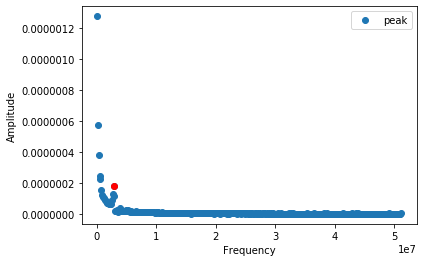

In [114]:
x=power
peaks, pr = find_peaks(x, distance=100)
peaks2, _ = find_peaks(x, prominence=0.00000008)      # BEST!
peaks3, _ = find_peaks(x, width=5)
peaks4, _ = find_peaks(x, prominence=0.00000008,distance=100)     # Required vertical distance to its direct neighbouring samples, pretty useless
plt.subplot(2, 2, 1)
plt.plot(peaks, x[peaks], "xr"); plt.plot(x); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, x[peaks2], "ob"); plt.plot(x); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, x[peaks3], "xg"); plt.plot(x); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, x[peaks4], "xk"); plt.plot(x); plt.legend(['threshold'])
plt.show()

fig, ax = plt.subplots()
ax.plot(sample_freq,x,'o'); plt.plot(sample_freq[19], x[19],'or'); plt.legend(['peak'])
ax.set_xlabel('Frequency')
ax.set_ylabel('Amplitude')



In [172]:
print(peaks2, ft[peaks2])
window=np.array([peaks2[0]-4,peaks2[0]-3,peaks2[0]-2, peaks2[0]-1, 
                              peaks2[0], peaks2[0]+1, peaks2[0]+2, 
                 peaks2[0]+3],peaks2[0]+4)
ft[22]

[19] [7.98354224e-08+1.62009298e-07j]


(1.612997006196666e-08+1.2903741142784714e-08j)

##### Polyfitting

In [116]:
new_freq=np.delete(sample_freq, [0,17,18,19,20,21])
new_ft_mag = np.delete(power, [0,17,18,19,20,21])

def func(x, a, b):
    return a * 1/(x) + b

popt, pcov = curve_fit(func, new_freq, new_ft_mag, p0=[0.1,0])
ffit=func(new_freq, *popt)

print(popt)

fig, ax = plt.subplots()
ax.plot(new_freq, new_ft_mag, "og", markersize=2);
ax.plot(sample_freq, power)
ax.plot(new_freq, func(new_freq, *popt),'r')
#ax.set(xlim=[-2e6,4e7], title=' remove peak data points')



[9.56339577e-02 2.35786530e-09]


In [131]:
fig, ax = plt.subplots()
ax.plot(sample_freq, power, "o", markersize=2)
ax.plot(sample_freq[window], ffit[window], "og")
ax.plot(sample_freq[window], power[window], "ok");
ax.set(title='Peaks removed and taken from fit')
ax.set_xlim(0,0.4e7)

(0, 4000000.0)

In [153]:
test=ft.copy()
test[window]=0

fig, ax= plt.subplots()
ax.plot(sample_freq, ft, "o", markersize=2)

ax.plot(sample_freq, test, 'k')
ax.set_xlim(0,0.4e7)


(0, 4000000.0)

In [154]:
s = np.fft.irfft(test, n=N)
x=fd_osc[1][:,0]#[0:rounded_length]
fig, ax=plt.subplots()
ax.plot(x, s)


In [149]:
y=fd_osc[1][:,1]#[0:rounded_length]
x=fd_osc[1][:,0]#[0:rounded_length]

notch_freq=ft[peaks2].real
q_factor=30
sample_freq=1/step
b_notch, a_notch = signal.iirnotch(notch_freq, q_factor, sample_freq)
freq, h = signal.freqz(b_notch, a_notch, fs=sample_freq)

y_notched= signal.filtfilt(b_notch, a_notch, y)
plt.plot(x,y_notched,'r')
plt.plot(x,y)


LinAlgError: Singular matrix

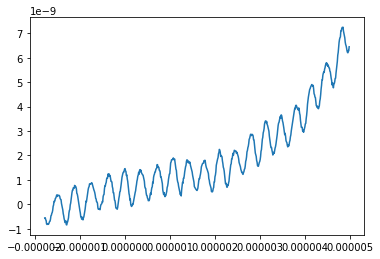

In [188]:
sos = signal.butter(100, (power[15], power[22]), btype='bandstop', output='sos')
filtered= signal.sosfilt(sos, y)

fig, ax= plt.subplots()
ax.plot(x, filtered)


In [177]:




sos = signal.butter(10, (power[15].real,power[22].real), btype='bandstop', output='sos')
filtered= signal.sosfilt(sos, y)

fig, ax= plt.subplots()
ax.plot(x, filtered)

-5.1553117280851726e-08

In [173]:
ft[22].real

1.612997006196666e-08